In [1]:
#the goals of this assignment include:
#1. write isolation forest algorithm from scratch
#2. apply the algorithm to a dataset
#3. evaluate the performance of the algorithm
#4. write a report on the results

#the sources for this assignment are as follows:
#1 assignment7.pdf, https://d2l.sdbor.edu/d2l/le/dropbox/1911312/1282003/DownloadAttachment?fid=48071356
#2 https://en.wikipedia.org/wiki/Isolation_forest
#3 https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf


#the structure of the code is as follows:
#1. import libraries
#2. Use howework framework to define data location
#3. define classes
#4. define functions
#5. run the code



In [2]:
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import os
from graphviz import Digraph

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from IPython.display import Image

In [3]:
homework_data_path = '\\..\\data\\'
homework_data_file = 'X_and_y.npz'

#check if data file exists
if not os.path.exists(file_path := os.getcwd() + homework_data_path + homework_data_file):
    print(f'{file_path} does not exist. Exiting.')
    exit()

report_folder = '\\report\\'
report_images = report_folder + 'resources\\images\\'

#check if the folder exists
if not os.path.exists(report_image_path := os.getcwd() + report_images):
    os.makedirs(os.getcwd() + report_images)
    
if not os.path.exists(os.getcwd() + report_images):
    print(f'{report_image_path} could not be created')
    exit()

print(f'Using {report_image_path} for report images.')

X_and_y = np.load(file_path)
print(f'{file_path} loaded successfully. Data shape is {X_and_y["X"].shape} and {X_and_y["y"].shape}.')
X_train, X_test, y_train, y_test = train_test_split(X_and_y['X'], X_and_y['y'], test_size=0.2, random_state=42)

Using h:\dev\git\csc730\assignment 7\report\resources\images\ for report images.
h:\dev\git\csc730\assignment 7\..\data\X_and_y.npz loaded successfully. Data shape is (6960, 784) and (6960,).


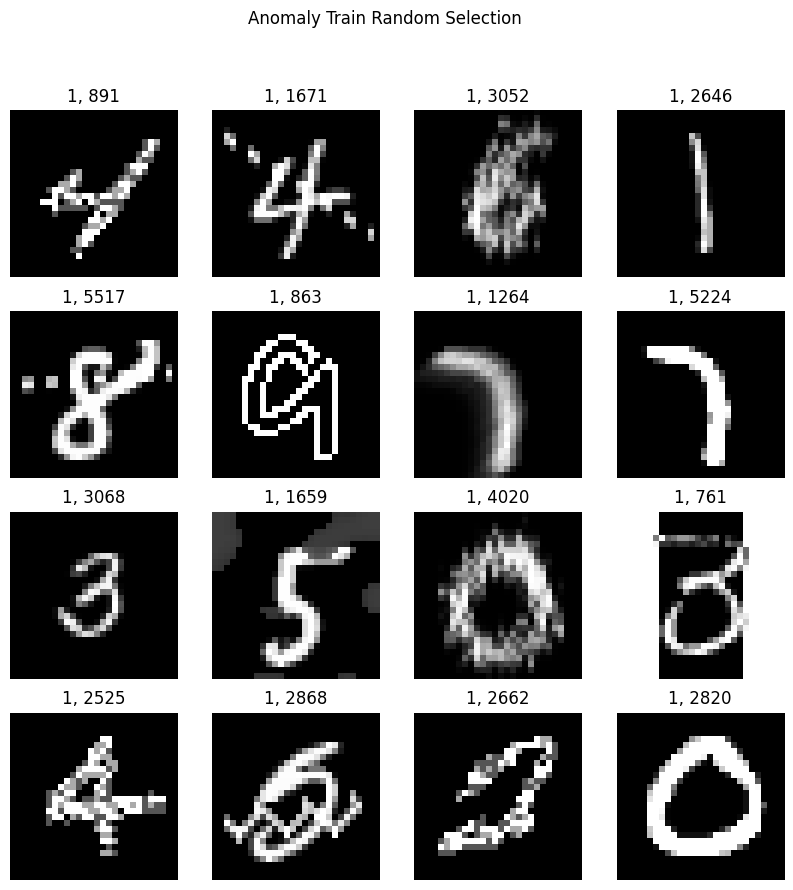

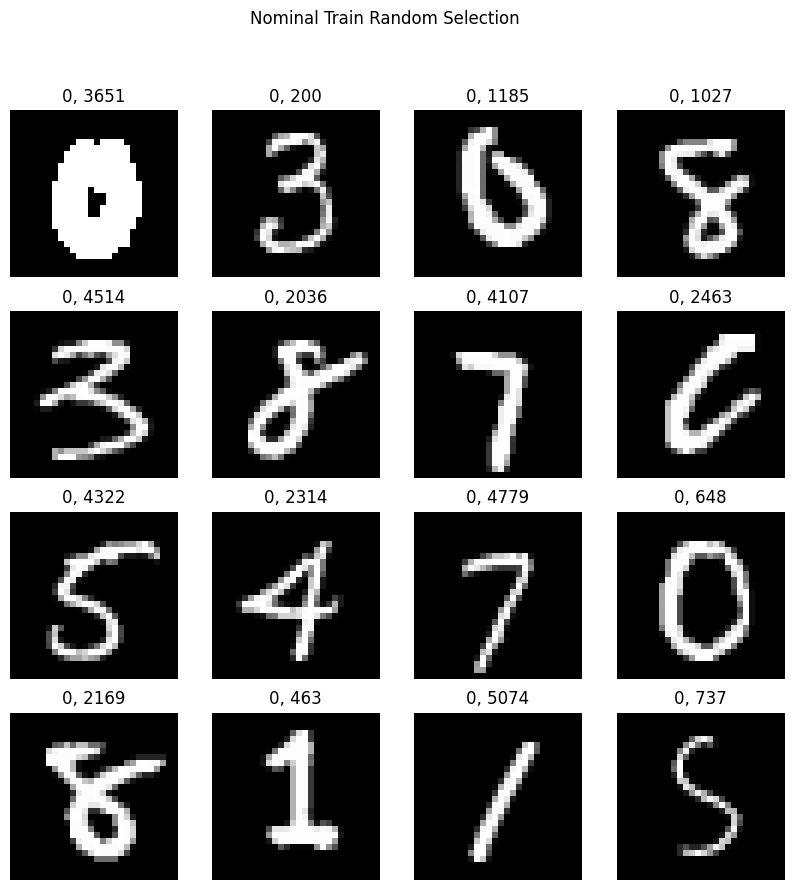

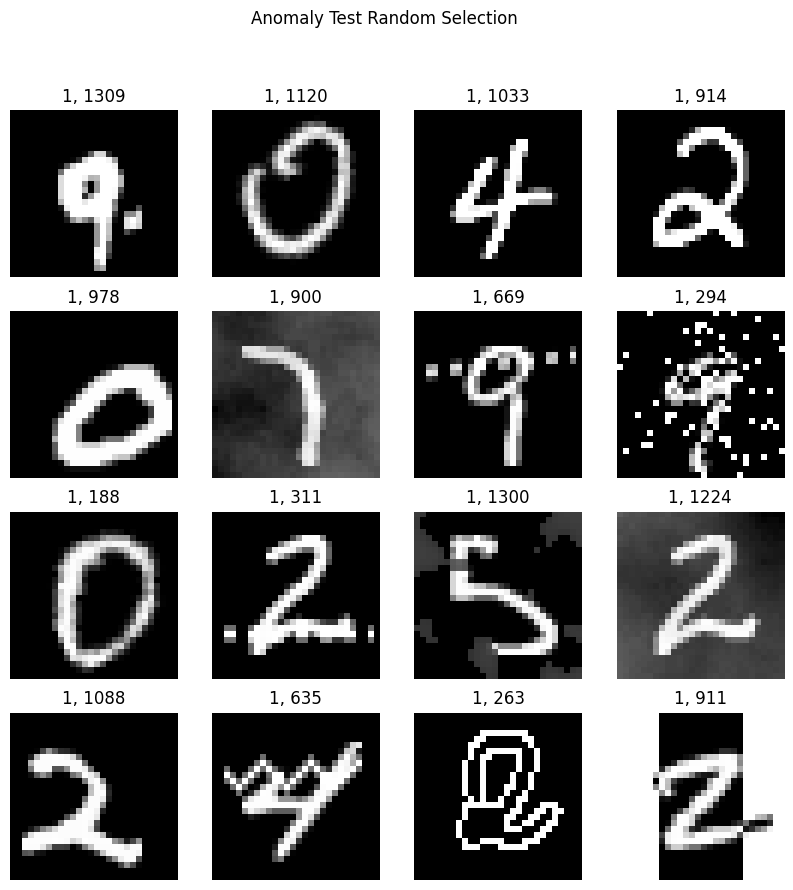

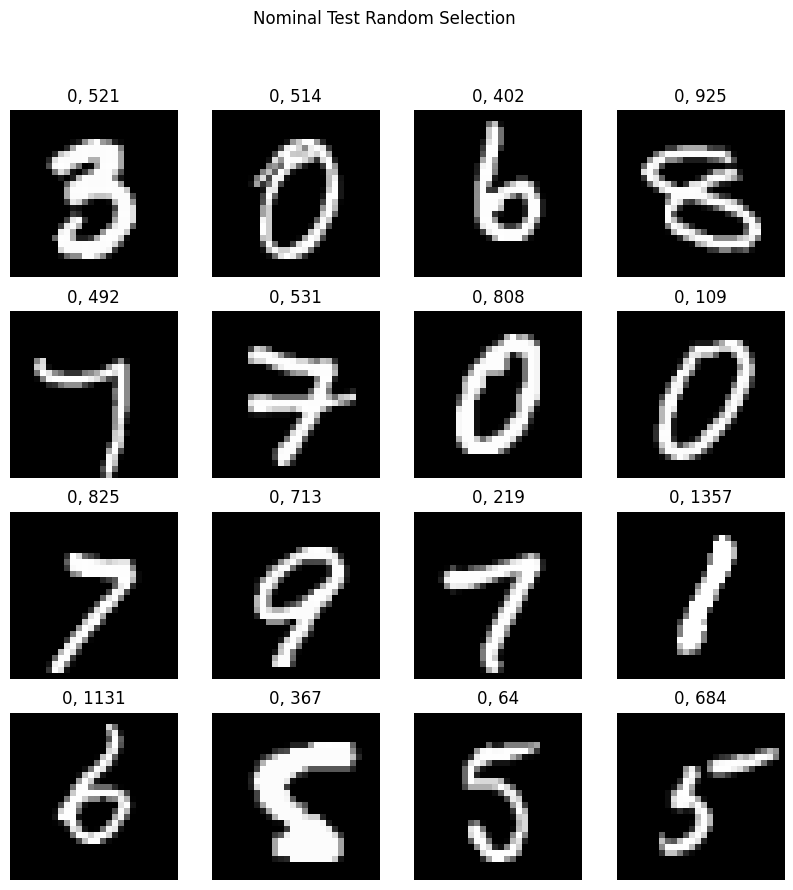

In [4]:
#generate random selection of images
#subplot of x_test with y_test labels

#select 16 random index from X_train where y_train is 1, anomaly_train_indexes
#select 16 random index from X_train where y_train is 0, nominal_train_indexes
#select 16 random index from X_test where y_test is 1, anomaly_test_indexes
#select 16 random index from X_test where y_test is 0, nominal_test_indexes

anomaly_train_indexes = np.random.choice(np.where(y_train == 1)[0], 16, replace=False)
nominal_train_indexes = np.random.choice(np.where(y_train == 0)[0], 16, replace=False)
anomaly_test_indexes = np.random.choice(np.where(y_test == 1)[0], 16, replace=False)
nominal_test_indexes = np.random.choice(np.where(y_test == 0)[0], 16, replace=False)



#generate selection of images from 


fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = anomaly_train_indexes[i*4 + j]
        ax[i, j].imshow(X_train[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_train[index]}, {index}')
        ax[i, j].axis('off')

plt.suptitle('Anomaly Train Random Selection')
plt.savefig(report_image_path + '_anomaly_train_random_selection.png')
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = nominal_train_indexes[i*4 + j]
        ax[i, j].imshow(X_train[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_train[index]}, {index}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Train Random Selection')        
plt.savefig(report_image_path + '_nominal_train_random_selection.png')
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = anomaly_test_indexes[i*4 + j]
        ax[i, j].imshow(X_test[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_test[index]}, {index}')
        ax[i, j].axis('off')

plt.suptitle('Anomaly Test Random Selection')        
plt.savefig(report_image_path + '_anomaly_test_random_selection.png')
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = nominal_test_indexes[i*4 + j]
        ax[i, j].imshow(X_test[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y_test[index]}, {index}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Test Random Selection')        
plt.savefig(report_image_path + '_nominal_test_random_selection.png')
plt.show()

In [39]:
def generate_pr_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')    
    return fig, ax, pr_auc, precision, recall

def generate_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc='lower right')

    return fig, ax, roc_auc, fpr, tpr

Sklearn Isolation Forest created with 100 trees


Text(0.5, 1.0, 'Sklearn Isolation Forest Precision Recall Curve\nUsing predict')

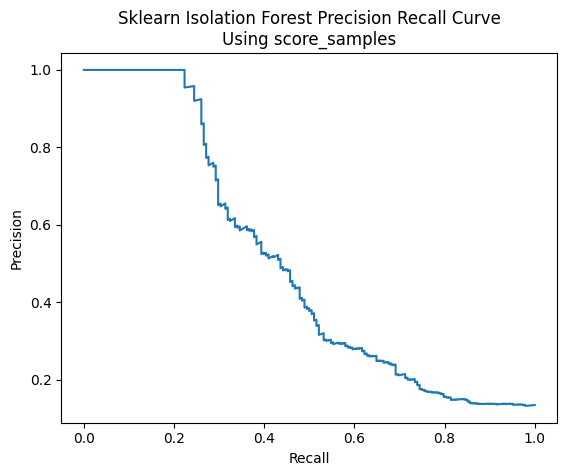

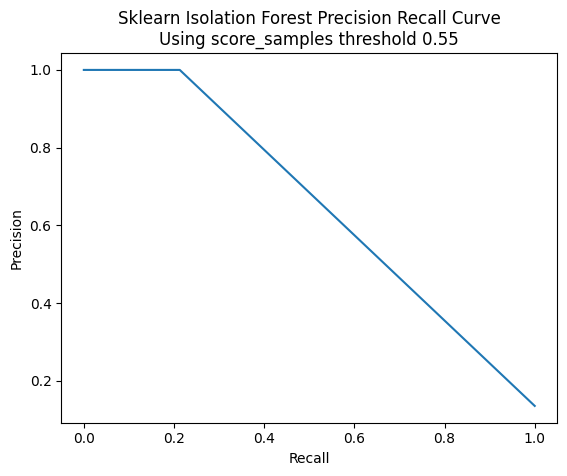

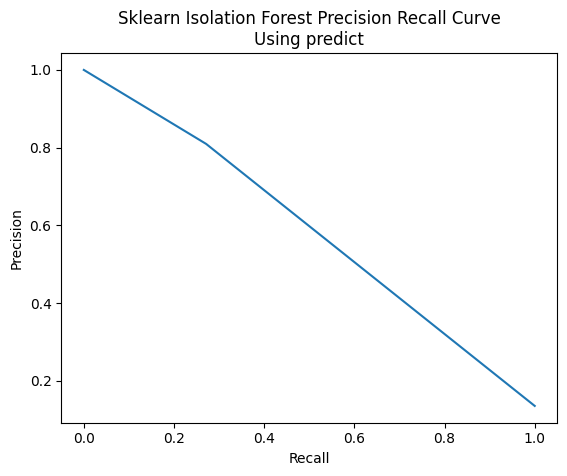

In [58]:
#use iforest from sklearn
from sklearn.ensemble import IsolationForest as skIsolationForest
sk_iforest = skIsolationForest( n_estimators=100, random_state=42)
sk_iforest.fit(X_train)
print(f'Sklearn Isolation Forest created with {len(sk_iforest.estimators_)} trees')

y_score = sk_iforest.predict(X_test)*-1
y_pred_score_sk = sk_iforest.score_samples(X_test)*-1

fig, ax, _,_,_ = generate_pr_curve(y_test, y_pred_score_sk)
ax.set_title('Sklearn Isolation Forest Precision Recall Curve\nUsing score_samples')
fig, ax, _,_,_ = generate_pr_curve(y_test, y_pred_score_sk>0.55)
ax.set_title('Sklearn Isolation Forest Precision Recall Curve\nUsing score_samples threshold 0.55')
fig, ax, _,_,_ = generate_pr_curve(y_test, y_score)
ax.set_title('Sklearn Isolation Forest Precision Recall Curve\nUsing predict')

In [20]:
class isolation_tree_node:
    def __init__(self, left=None, right=None, split_feature=None, split_value=None, parent=None, height=None, index=0):
        self.parent = parent
        self.height = height
        self.left = left
        self.right = right
        self.split_feature = split_feature
        self.split_value = split_value
        self.index = index

class isolation_tree:    
    _exNodeCount = 0
    _inNodeCount = 0
    _max_height_reached = 0
    
    def __init__(self, max_height):
        self.max_height = max_height        
        self.root = None
        
    def _get_next_in_node_index(self):
        self._inNodeCount+=1
        return self._inNodeCount-1
    
    def _get_next_ex_node_index(self):
        self._exNodeCount+=1
        return self._exNodeCount-1
    
    def _check_max_height(self, height):
        if height > self._max_height_reached:
            self._max_height_reached = height
        return height
            
    def _get_max_height_reached(self):
        return self._max_height_reached
    
    #algorithm #1
    def fit(self, x):
        self.root = self._split(x, 0)
        #traverse the tree and set parent nodes
        stack = [(self.root, None)]
        while stack:
            node, parent = stack.pop()
            node.parent = parent
            if node.left is not None:
                stack.append((node.left, node))
            if node.right is not None:
                stack.append((node.right, node))


    #algorithm #2
    def _split(self, x, height):
        #if X can not be divided then return external node
        if len(x) <= 1 or height >= self.max_height:
            #self.exNodeCount+=1
            return isolation_tree_node(height = height, index = self._get_next_ex_node_index())# self.exNodeCount) #return exNode

        #else
        split_feature = np.random.randint(0, x.shape[1])
        split_value = np.random.uniform(x[:, split_feature].min(), x[:, split_feature].max())

        left_indices = x[:, split_feature] < split_value
        x_left, x_right = x[left_indices], x[~left_indices]

        #print(f'Height: {height}, Split Feature: {split_feature}, Split Value: {split_value}, Left: {len(x_left)}, Right: {len(x_right)}')
        
        return isolation_tree_node(
            left=self._split(x_left, height + 1),
            right=self._split(x_right, height + 1),
            split_feature=split_feature,
            split_value=split_value, 
            height= self._check_max_height(height) ,
            index = self._get_next_in_node_index()          
        ) #return inNode

    #algorithm #3
    def path_length(self, x):
        node = self.root
        path_length = 0

        while node.left is not None and node.right is not None:            
            if x[node.split_feature] < node.split_value:
                node = node.left
            else:
                node = node.right
            path_length += 1

        return path_length

    @staticmethod
    def _c(n):
        if n > 2:
            return 2 * (np.log(n - 1) + np.euler_gamma) - (2 * (n - 1) / n)

        if n == 2:
            return 1
        
        return 0
    
    
    def visualize_tree(self):
        dot = Digraph()

        def add_node(node, parent_name=None):
            if node is None:
                return

            node_name = f"node_{id(node)}"
            if node.left is None and node.right is None:
                if node.parent.left == node:
                    dot.node(node_name, label=f"ExNode# {node.index}, h: {node.height}\nFeature: {node.parent.split_feature} < Value: {node.parent.split_value:.2f}", shape="box")
                else:
                    dot.node(node_name, label=f"ExNode# {node.index}, h: {node.height}\nFeature: {node.parent.split_feature} > Value: {node.parent.split_value:.2f}", shape="box")
                    
                
            else:
                dot.node(node_name, label=f"inNode# {node.index}, Feature: {node.split_feature}\nValue: {node.split_value:.2f}", shape="ellipse")

            if parent_name is not None:
                dot.edge(parent_name, node_name)

            add_node(node.left, node_name)
            add_node(node.right, node_name)

        add_node(self.root)    
        
        dot.attr(label=f'Isolation Tree - Leafs count {self._exNodeCount}, Height Reached {self._max_height_reached}', labelloc='t', fontsize='64')
        
        return dot

class isolation_forest:
    ANOMALY = 1
    NOMINAL = 0
    def __init__(self, n_trees, sub_samples, max_height):
        self.n_trees = n_trees
        self.sub_samples = sub_samples
        self.max_height = max_height   
        self.trees = []
        

    def fit(self, x):
        for _ in range(self.n_trees):
            if self.sub_samples is None:
                sample_indices = np.arange(x.shape[0])
            else:
                sample_indices = np.random.choice(x.shape[0], size=self.sub_samples, replace=False)
                
            x_sample = x[sample_indices]

            tree = isolation_tree(self.max_height)
            tree.fit(x_sample)
            self.trees.append(tree)

    def anomaly_scores(self, x):
        scores = []
        for xi in x:
            path_lengths = [tree.path_length(xi) for tree in self.trees]
            score = 2 ** (-np.mean(path_lengths) / isolation_tree._c(len(x)))
            scores.append(score)
        return np.array(scores)

    def predict(self, x, threshold):
        scores = self.anomaly_scores(x)
        
        if threshold is None:
            raise ValueError('threshold must be provided')          
        
        return np.where(scores > threshold, self.ANOMALY, self.NOMINAL)

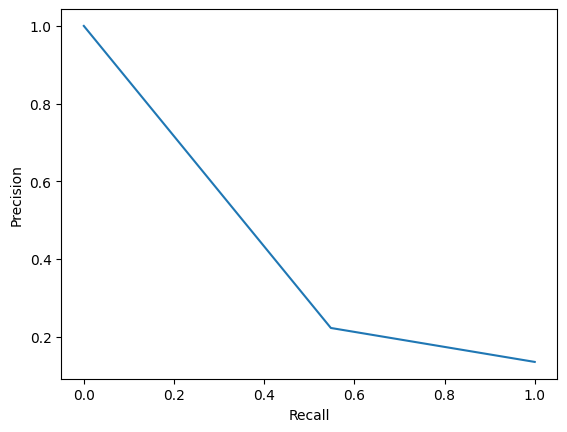

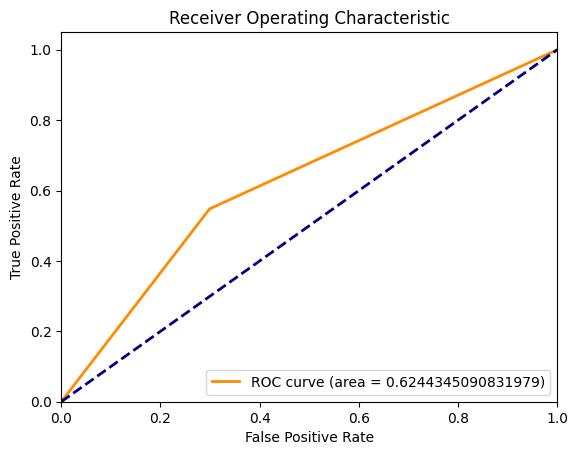

In [34]:

kj_iforest = isolation_forest( n_trees=1000, sub_samples=32, max_height=100)
kj_iforest.fit(X_train)
#print(f'Sklearn Isolation Forest created with {len(sm_iforest.estimators_)} trees')

#generate precision-recall curve for the isolation forest
y_score = kj_iforest.predict(X_test, 0.5)





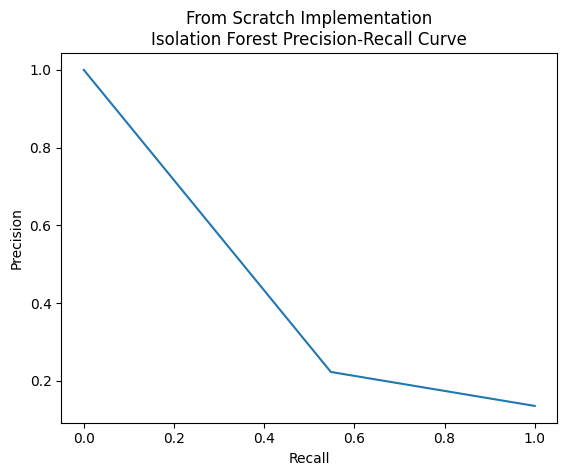

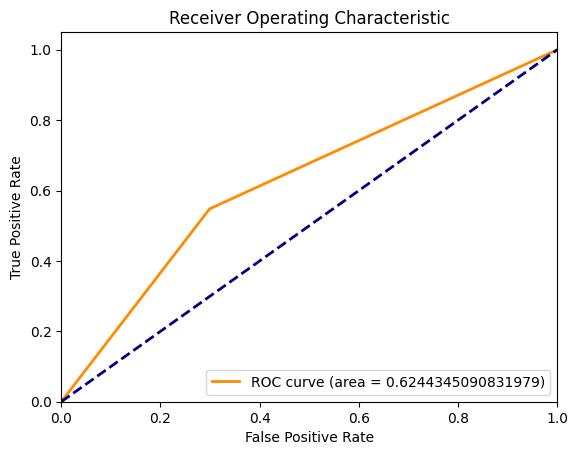

In [38]:
fig, ax, _, _, _ = generate_pr_curve(y_test, y_score)
ax.set_title('From Scratch Implementation\nIsolation Forest Precision-Recall Curve')
fig.savefig(report_image_path + 'scratch_pr_curve.png')
fig, ax, _, _, _ = generate_roc_curve(y_test, y_score)

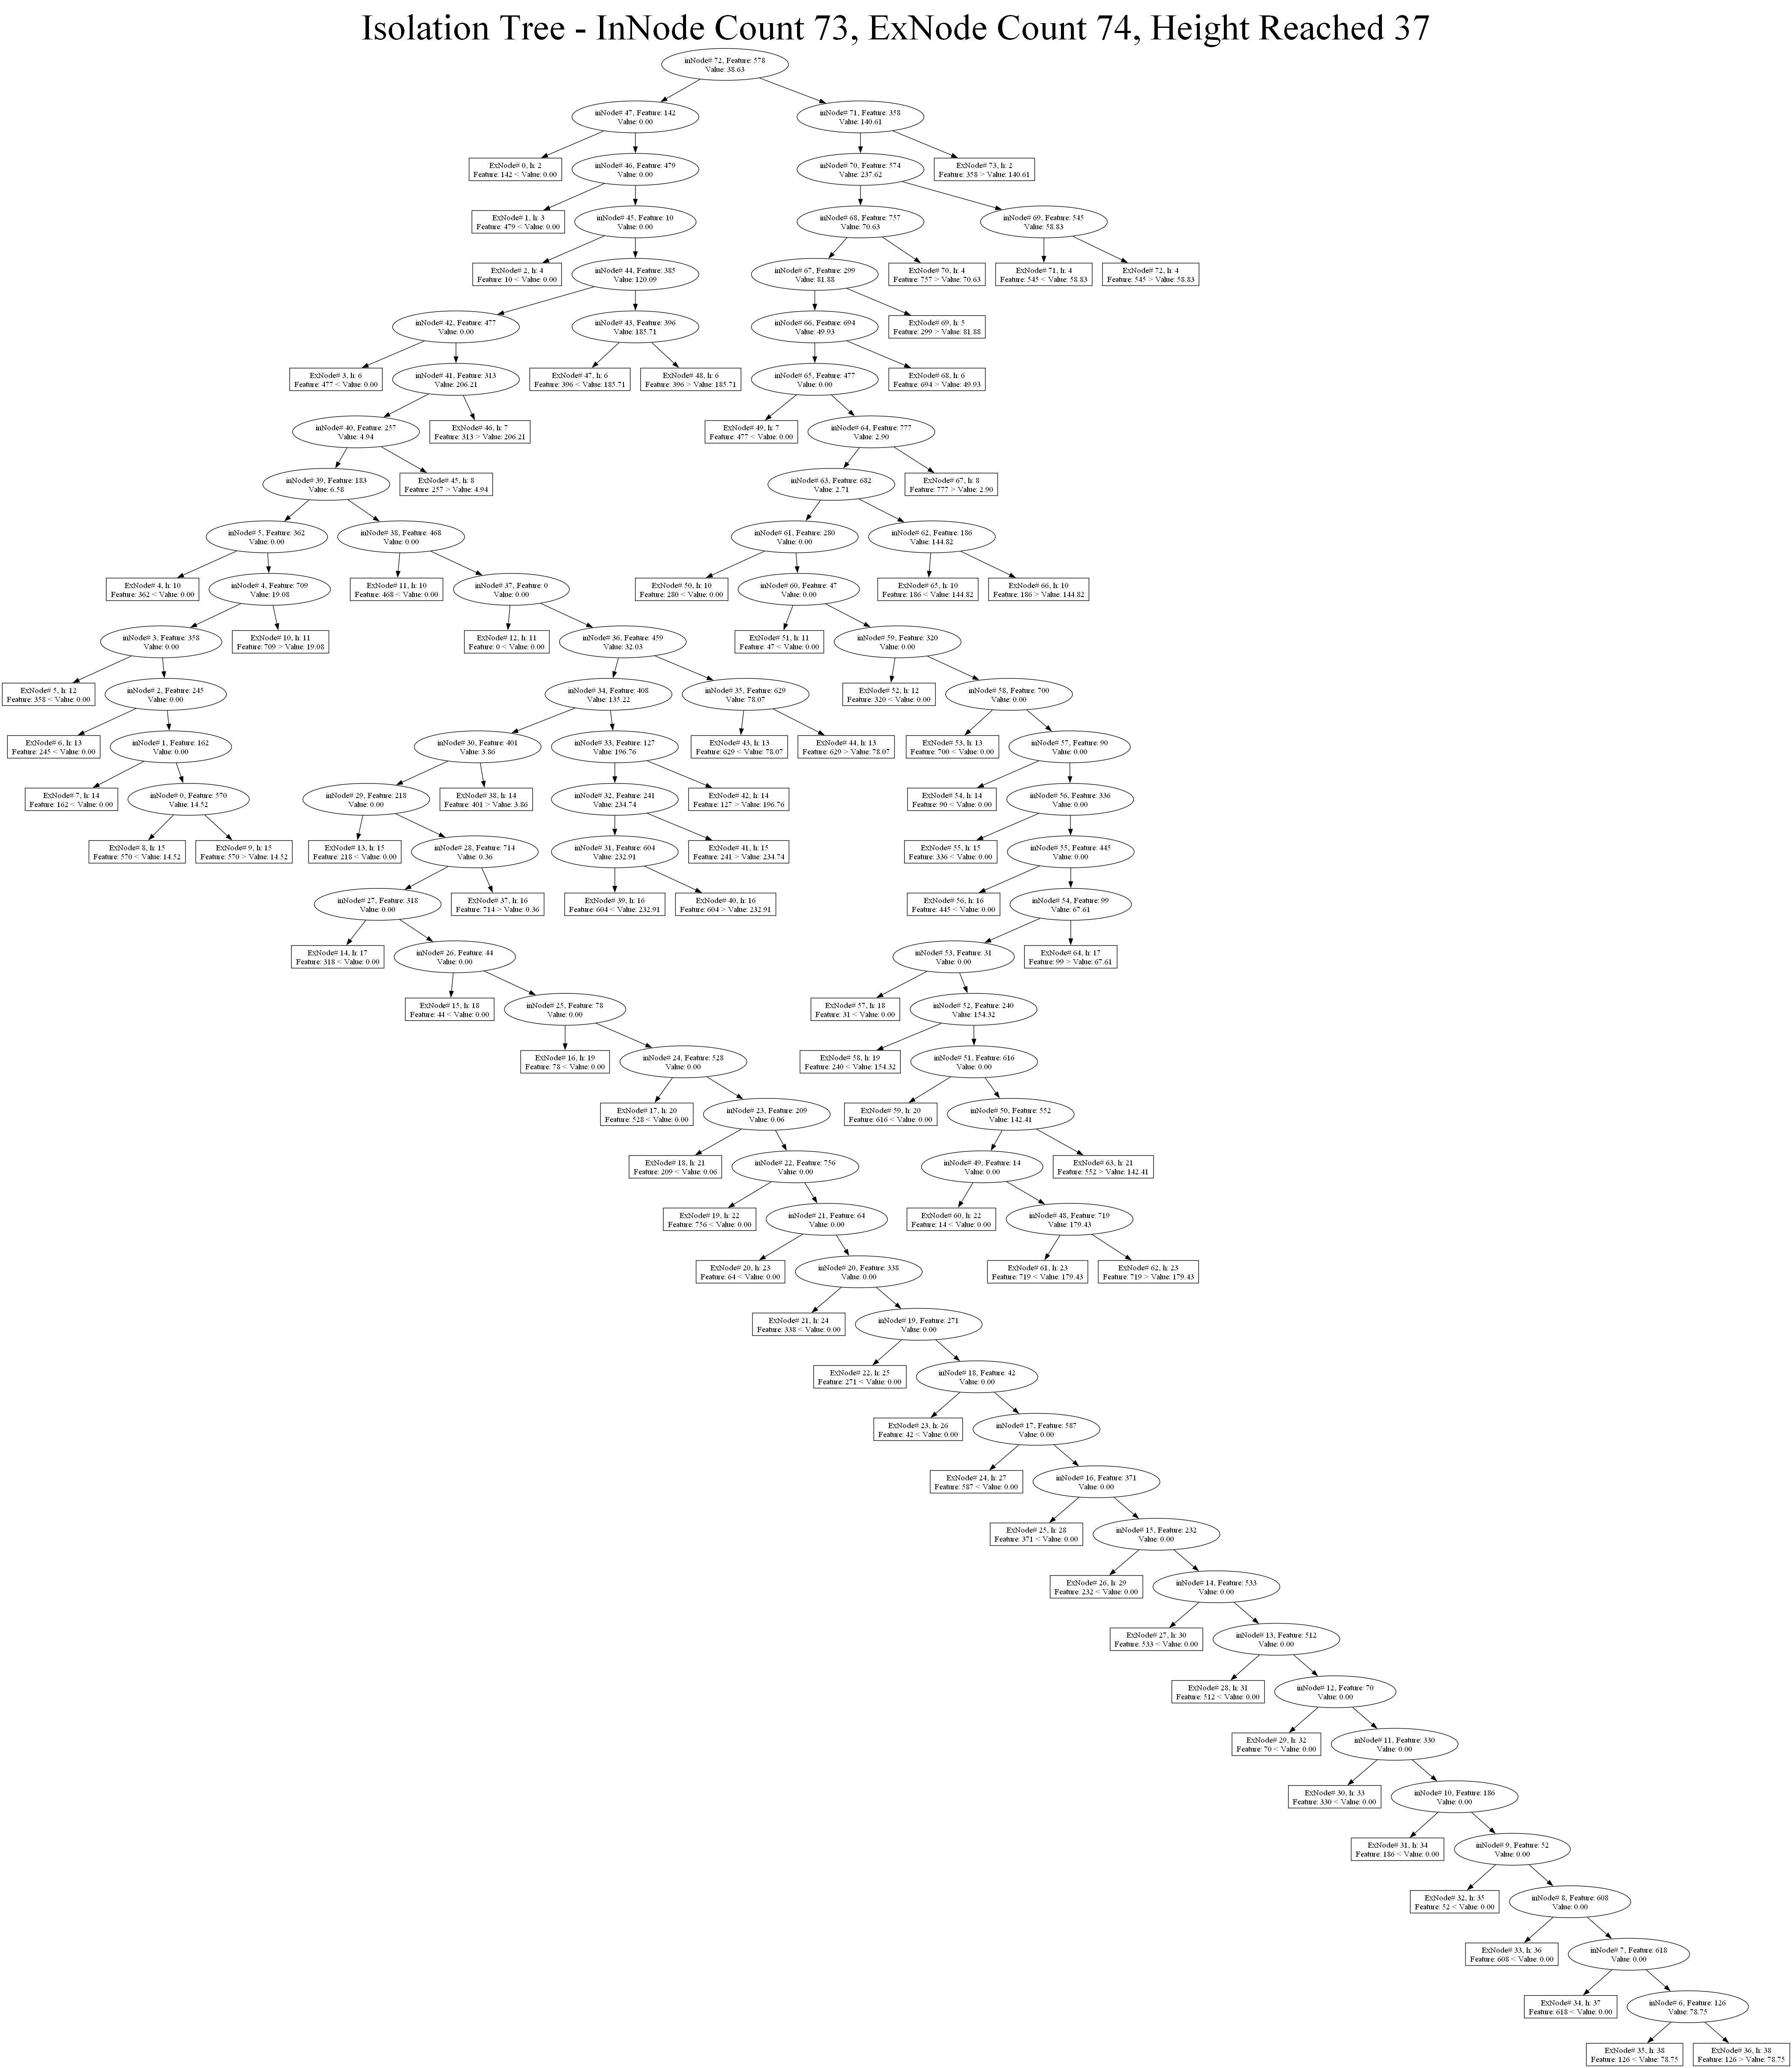

'h:\\dev\\git\\csc730\\assignment 7\\report\\resources\\images\\itree_graph.svg'

In [24]:
itree_graph = kj_iforest.trees[1].visualize_tree()



display(Image(itree_graph.pipe(format='png')))
#save figure as png
itree_graph.render(report_image_path + 'itree_graph', format='svg', cleanup=True)


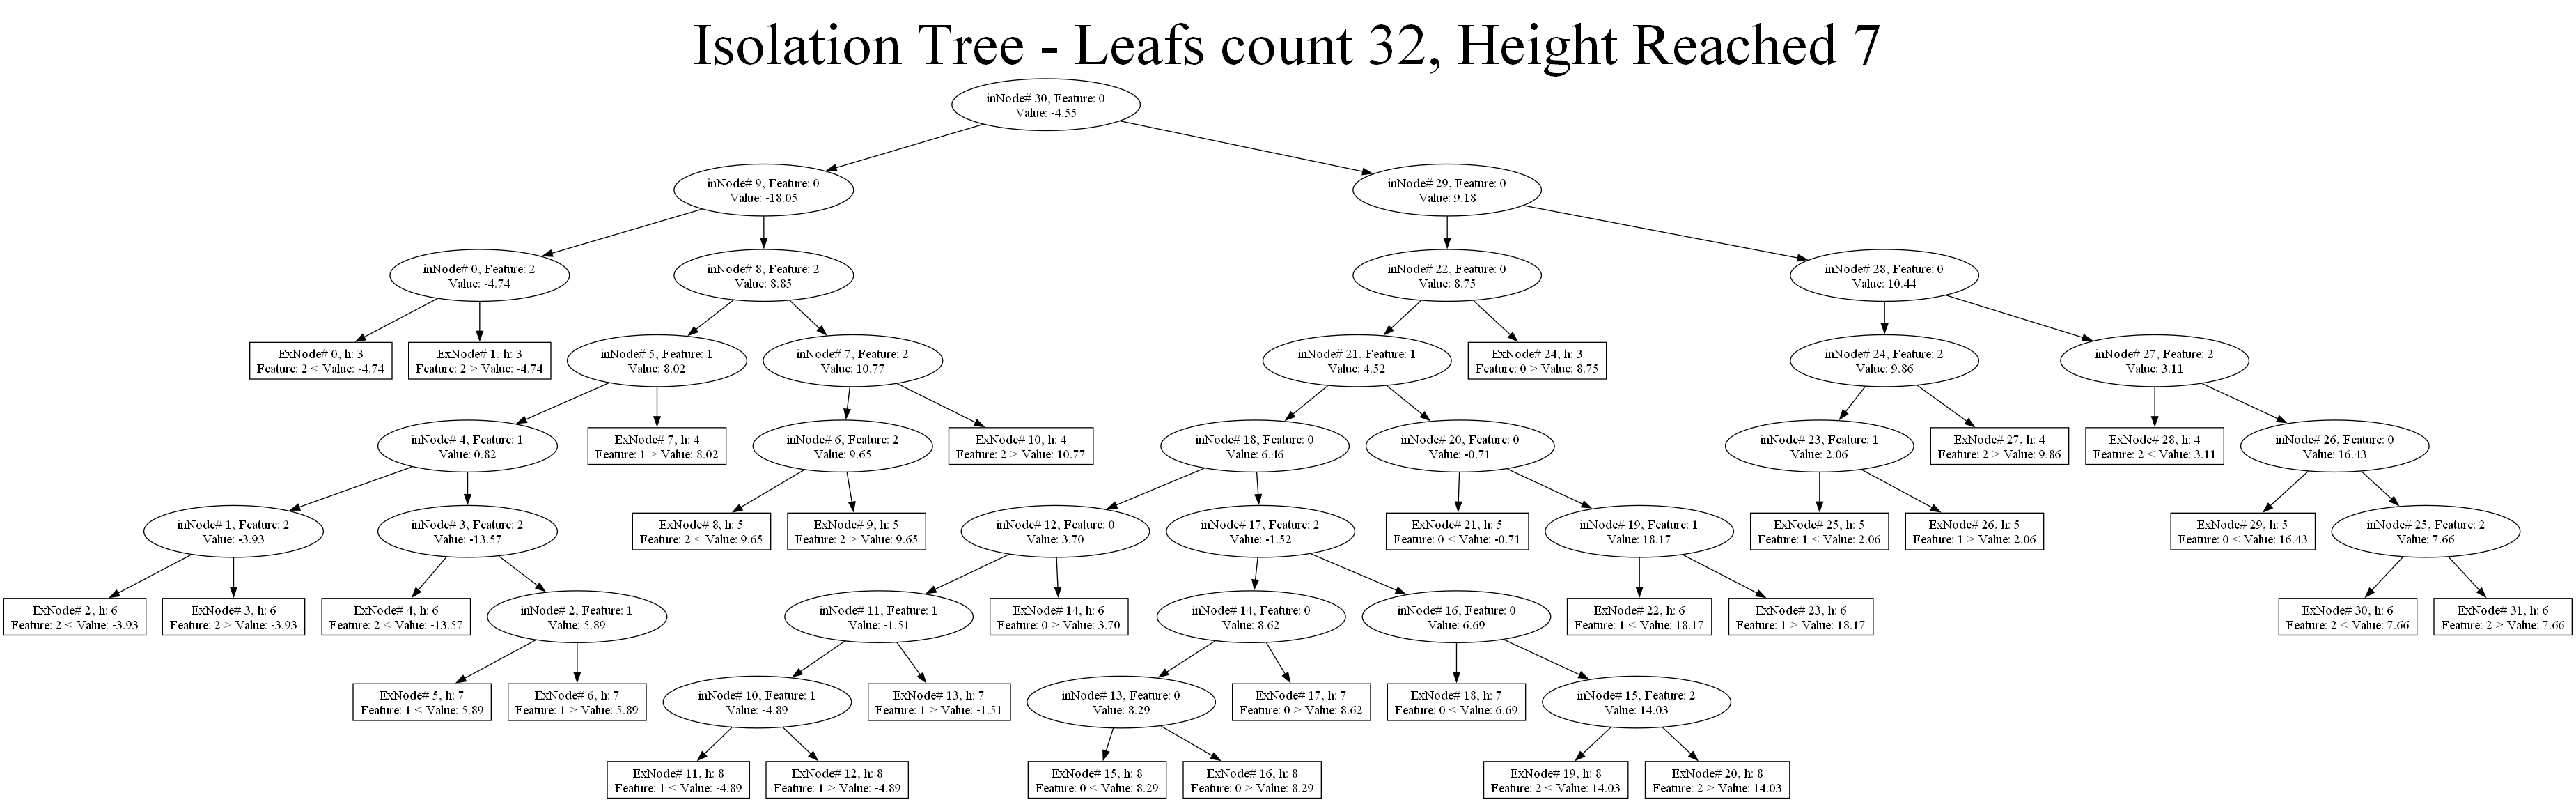

'h:\\dev\\git\\csc730\\assignment 7\\report\\resources\\images\\itree_tsne_graph.svg'

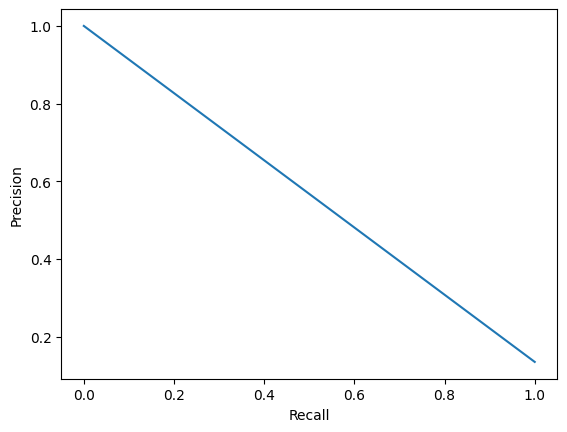

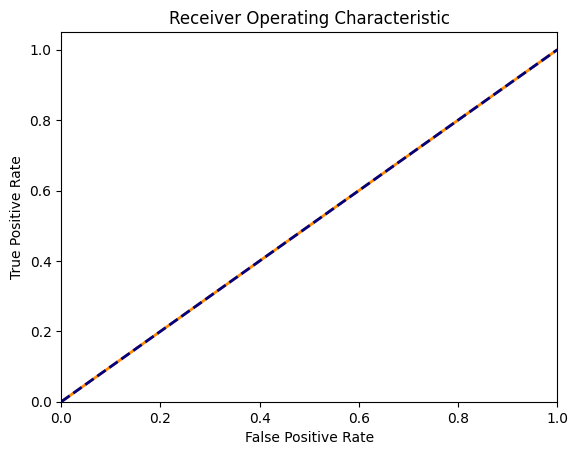

In [28]:
#use t-sne to reduce the dimensionality of the data to 2 then run the isolation forest on the data
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_train)

kj_iforest_tsne = isolation_forest( n_trees=256, sub_samples=32, max_height=100)
kj_iforest_tsne.fit(X_tsne)

y_score = kj_iforest_tsne.predict(tsne.fit_transform(X_test), 0.6)

_ = generate_pr_curve(y_test, y_score)
_ = generate_roc_curve(y_test, y_score)

itree_graph_tsne = kj_iforest_tsne.trees[1].visualize_tree()



display(Image(itree_graph_tsne.pipe(format='png')))
#save figure as png
itree_graph_tsne.render(report_image_path + 'itree_tsne_graph', format='svg', cleanup=True)

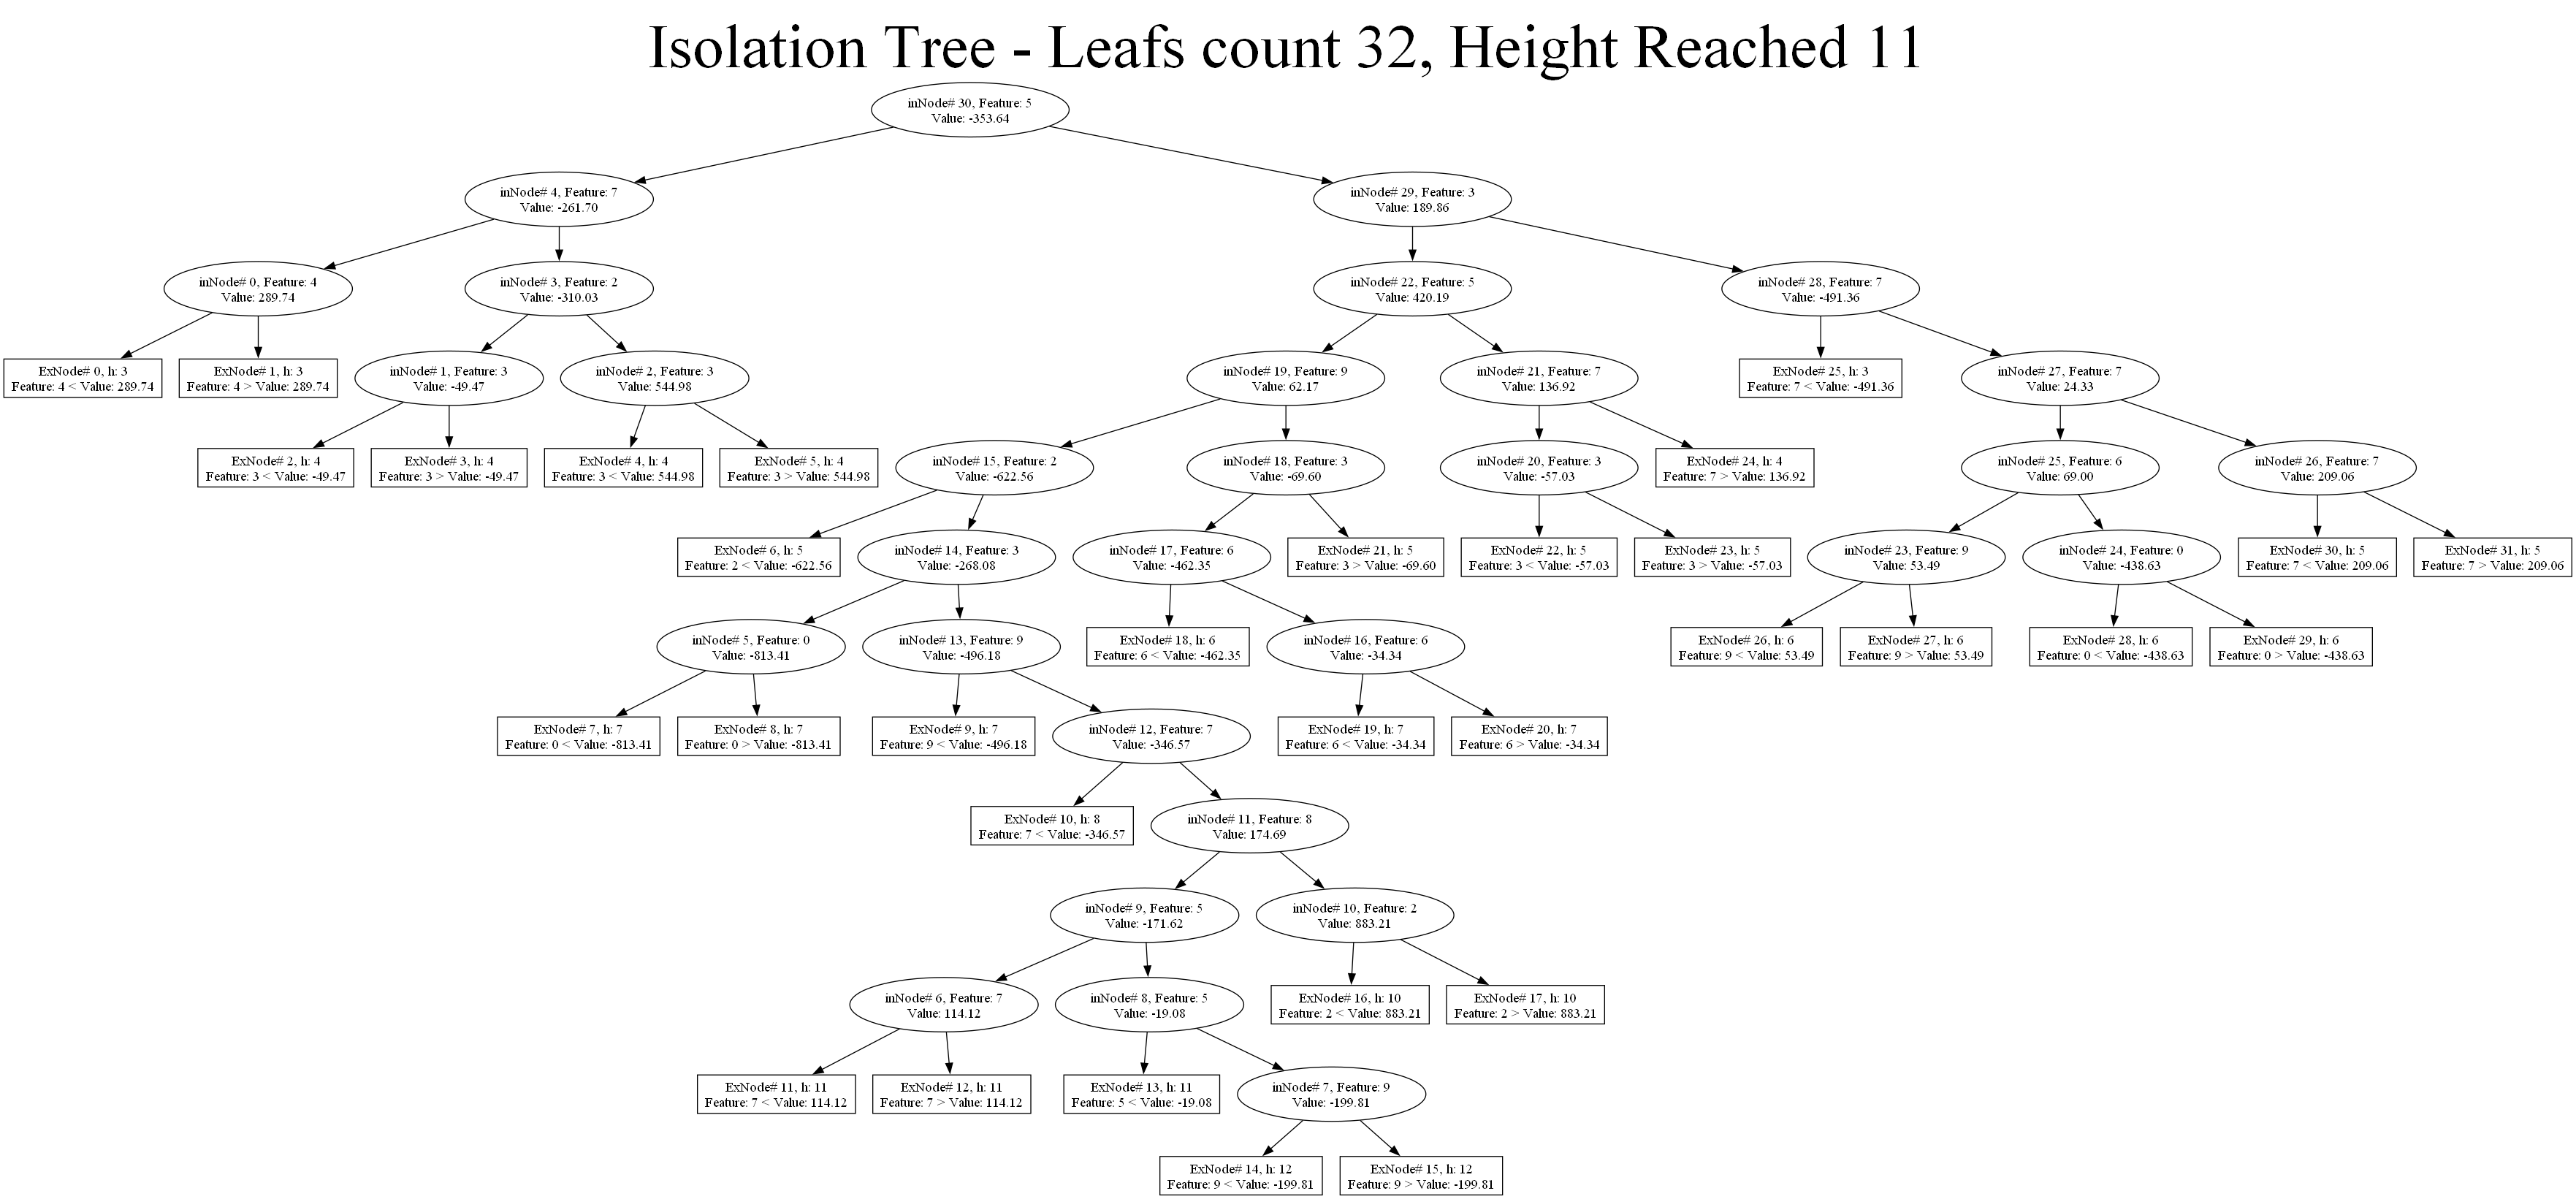

'h:\\dev\\git\\csc730\\assignment 7\\report\\resources\\images\\itree_pca_graph.svg'

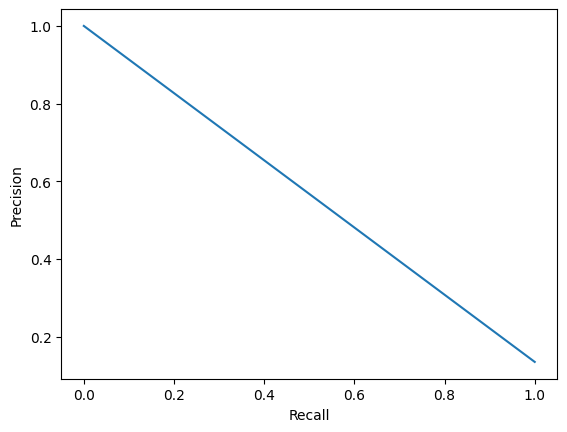

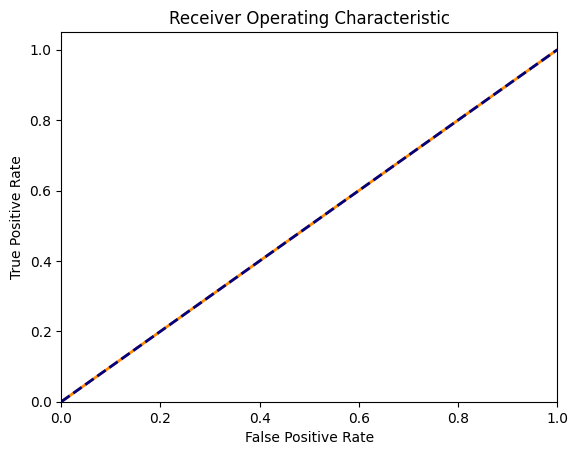

In [31]:
#use pca to reduce the dimensionality of the data to 2 then run the isolation forest on the data

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X_train)
X_pca = pca.transform(X_train)

kj_iforest_pca = isolation_forest( n_trees=256, sub_samples=32, max_height=100)
kj_iforest_pca.fit(X_pca)

y_score = kj_iforest_pca.predict(pca.transform(X_test), 0.6)

_ = generate_pr_curve(y_test, y_score)
_ = generate_roc_curve(y_test, y_score)

itree_graph_pca = kj_iforest_pca.trees[1].visualize_tree()



display(Image(itree_graph_pca.pipe(format='png')))
#save figure as png
itree_graph_pca.render(report_image_path + 'itree_pca_graph', format='svg', cleanup=True)


In [ ]:
#save data to npz for debugging

np.savez('iforest_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_score=y_score, anomaly_train_indexes=anomaly_train_indexes, nominal_train_indexes=nominal_train_indexes, anomaly_test_indexes=anomaly_test_indexes, nominal_test_indexes=nominal_test_indexes)